In [1]:
#!pip install --upgrade azure-cognitiveservices-vision-face
#!pip install ---upgrade azure-storage-blob
#!pip install Pillow
#!pip install opencv-python
#!pip install python-decouple
#!pip install bokeh

In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import datetime as dt
from decouple import config
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

In [3]:
API_KEY = '077054fbed0e4d5982d9ec2edd104542'
API_ENDPOINT = 'https://arpanet-faceapi.cognitiveservices.azure.com/'

face_client = FaceClient(API_ENDPOINT, CognitiveServicesCredentials(API_KEY))

In [4]:
def getRectangle(faceDictionary):
        rect = faceDictionary.face_rectangle
        left = rect.left
        top = rect.top
        right = left + rect.width
        bottom = top + rect.height
        return ((left, top), (right, bottom))

def drawFaceData(img_path, detected_faces):
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    detected_attributes = ""
    student_id = ""
    pos_y = 30
    for face in detected_faces:
        draw.rectangle(getRectangle(face), outline='red')
        detected_attributes = face.face_attributes.as_dict()
        student_id = findStudent(students, face.face_id)
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    try:
        emotions = detected_attributes['emotion']
        if emotions:
            for key,value in emotions.items():
                atr = key + ' : ' + str(value)
                cv2.putText(img, atr , (30, pos_y), font, 1, (0, 0, 255), 2, cv2.LINE_4)
                pos_y += 30
    except:
        pass
    
    try:
        if len(student_id):
            cv2.putText(img, 'Student: ' + student_id, (30, 420), font, 1, (0, 0, 255), 2, cv2.LINE_4)
        else:
            cv2.putText(img, 'Unknown Student', (30, 420), font, 1, (0, 0, 255), 2, cv2.LINE_4)
    except:
        cv2.putText(img, 'Unknown Student', (30, 420), font, 1, (0, 0, 255), 2, cv2.LINE_4)
    cv2.imshow('ARPANET Stream', img)

    
def drawUndetected(img_path):
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    font = cv2.FONT_HERSHEY_SIMPLEX
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'No Face Detected - Error Avoided', (30, 420), font, 1, (0, 0, 255), 2, cv2.LINE_4)
    cv2.imshow('ARPANET Stream', img)
    
def getEmotionData(img_path, detected_faces):
    img = Image.open(img_path)
    draw = ImageDraw.Draw(img)
    detected_attributes = ""
    for face in detected_faces:
        detected_attributes = face.face_attributes.as_dict()
    try:
        emotions = detected_attributes['emotion']
        if emotions:
            max_emotion = max(emotions, key=emotions.get)
            max_emotion_value = emotions[max_emotion]
            return {'Timestamp':dt.datetime.now(), 'Emotion':max_emotion, 'Emotion_Value':max_emotion_value}
    except:
        return {'Timestamp':dt.datetime.now(), 'Emotion':'not paying attention', 'Emotion_Value':-1.0}

In [5]:
try:
    face_client.person_group.delete(person_group_id='101010101010')
except:
    pass

UTP_SEDE_PANAMA = '101010101010'
GROUP_ID = UTP_SEDE_PANAMA
PERSON_ID = '8-926-1807'
students = {}
student_img_url = 'https://arpanetstorage.blob.core.windows.net/reference-images/8_926_1807.jpeg'

In [6]:
face_client.person_group.create(person_group_id=GROUP_ID, name=GROUP_ID)
student = face_client.person_group_person.create(GROUP_ID, PERSON_ID)
face_client.person_group_person.add_face_from_url(GROUP_ID, student.person_id, student_img_url)
face_client.person_group.train(GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        
        face_client.person_group.delete(person_group_id=PERSON_GROUP_ID)
        print('Training the person group has failed.')
        break
    time.sleep(5)

try:
    reference = face_client.face.detect_with_url(student_img_url, detection_model='detection_01')
    reference_id = reference[0].face_id
    students[student.person_id] = {'person_id': PERSON_ID, 'reference_id': reference_id}
    print('Face Detect has succeeded.')
except BaseException as err:
    face_client.person_group.delete(person_group_id=GROUP_ID)
    print('Face Detect has failed.', 'Error:', err.message)

Training status: running.

Training status: succeeded.

Face Detect has succeeded.


In [7]:
def verifyResults(reference_id, detected_id):
    verify_result_same = face_client.face.verify_face_to_face(reference_id, detected_id)
    if verify_result_same.is_identical:       
        return True
    else:
        return False

def findStudent(students, detected_face_id):
    for student in students:
        student = students[student]
        if verifyResults(student['reference_id'], detected_face_id):
            return student['person_id']

In [8]:
img = 'img.jpeg'
img_path = os.path.join(os.getcwd(), img)

data = pd.DataFrame(columns=['Timestamp', 'Emotion', 'Emotion_Value'])

vid = cv2.VideoCapture(0)

while(True):
    
    ret, frame = vid.read()
    cv2.imwrite(img_path, frame)
    img_stream = open(img_path, "rb")
    
    try:
        detected_faces = face_client.face.detect_with_stream(image = img_stream, recognition_model='recognition_01', return_face_attributes = ['emotion'])
        drawFaceData(img_path, detected_faces)
    except:
        drawUndetected(img_path)
        
    record = getEmotionData(img_path, detected_faces)
    data = data.append(record, ignore_index = True)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

In [9]:
import bokeh.io
import statistics
from pathlib import Path
from bokeh.models import HoverTool, DatetimeTickFormatter
from bokeh.plotting import figure, show
import matplotlib.pyplot as plt

bokeh.io.reset_output()
bokeh.io.output_notebook()

Loading BokehJS ...

None


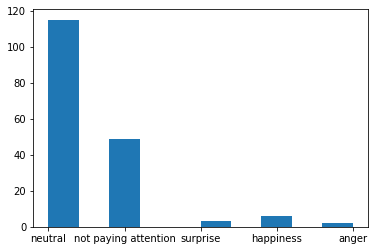

In [10]:
def freqdect(df):
    plt.hist(df['Emotion'])
    
print(freqdect(data))

In [11]:
def mean_of_class(df):    
    mean = df['Emotion_Value'].mean()
    if mean < 0:
        return f'Did not pay attention... Mean: {mean}'
    else:
        return f'Did pay attention... Mean: {mean}'
    
print(mean_of_class(data))

Did pay attention... Mean: 0.39471428571428574


In [12]:
def attention_analytics(df):
    _data = pd.DataFrame()
    std = df['Emotion_Value'].std() #Desviacion estandar
    median = df['Emotion_Value'].median() #Media
    mean = df['Emotion_Value'].mean()
    npa_count = df['Emotion'].loc[df['Emotion'] == 'not paying attention'].count()
    npa_pct = npa_count / df['Emotion'].count()
    score = 1 - npa_pct
    result = ''
    if score >= 0.8:
        result = 'Good Attention'
    elif (0.8 > score) and (score >= 0.5):
        result = 'Regular Attention'
    else:
        result = 'Lack of Attention'
    estudiante={'student_id':'8-926-1807','attention_mean':mean, 'attention_std':std, 'npa_count': npa_count, 'npa_pct': npa_pct, 'attention_score': score, 'result': result}
    _data = _data.append(estudiante,ignore_index=True)
    return _data[['student_id','attention_mean','attention_std','npa_count', 'npa_pct', 'attention_score', 'result']]
        
attention_analytics(data)

,student_id,attention_mean,attention_std,npa_count,npa_pct,attention_score,result
0,8-926-1807,0.394714,0.878353,49.0,0.28,0.72,Regular Attention


In [13]:
def attention_time_series(df):
    df['Timestamp_Str'] = df['Timestamp'].astype('string')
    TOOLS = 'save,pan,box_zoom,reset,wheel_zoom,hover'
    p = figure(title='Attention vs Time', plot_width=700, plot_height=700, tools=TOOLS)
    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Emotion_Value'
    p.select_one(HoverTool).tooltips = [
        ('index', '$index'),
        ('Time', '@Timestamp_Str'),
        ('Emotion', '@Emotion')
    ]
    p.circle(df['Timestamp'].loc[df.Emotion_Value == df.Emotion_Value.min()], df.Emotion_Value.min(), size = 10, color = 'red')
    p.line('Timestamp', 'Emotion_Value', line_color='blue', line_width = 3, source=df)
    show(p)
    df.drop(columns=['Timestamp_Str'])

attention_time_series(data)